# causalnex Trial 02

sklearnrライクなmethodを用いた因果グラフ推定。Lasso, pytorchを用いたNOTEARSの因果グラフ推定。

- DAGClassifier, DAGRegressor
- from_pandas_lasso, from_pandas(pytorch)

# 必要パッケージ インストール & import

In [1]:
!pip install causalnex
!pip install networkx
!pip install pgmpy
from IPython.display import clear_output
clear_output()

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx
import warnings; warnings.simplefilter("ignore")
%matplotlib inline

In [3]:
import causalnex
from causalnex.structure.notears import from_pandas , from_pandas_lasso
from causalnex.structure.pytorch import from_pandas as from_pandas_pytorch

from causalnex.structure import DAGClassifier, DAGRegressor

In [4]:
# networkx_util
from util.networkx_util import NetworkxUtil
nx_util = NetworkxUtil() # networkxの図示, printのためのutil

# サンプルデータ

In [5]:
def generate_sample_data(n_samples=1000):
    """
    サンプルデータ生成
    | c1 --> x1
    | c2 --> x1
    | c1 --> y
    | c2 --> y
    | x1 --> y
    | x2 は独立
    """
    np.random.seed(0)
    c1 = np.random.normal(0, 0.5, size=n_samples)
    c2 = np.random.choice(2, size=n_samples)

    np.random.seed(1)
    x1 = np.random.normal(1, 2, size=n_samples) + c1 + c2/10

    np.random.seed(2)
    y = np.random.uniform(-1,2, size=n_samples) + x1 + c1 + c2 /10

    np.random.seed(3)
    x2 = np.random.uniform(-2, 2, size=n_samples)
    raw_data = pd.DataFrame({"x1": x1, "y":y, "x2": x2, "c1": c1, "c2":c2})
    return raw_data

In [6]:
n_samples = 2000
struct_data = generate_sample_data(n_samples)

X = struct_data.drop(["y"], axis=1)
y = struct_data["y"]
print(X.shape)

(2000, 4)


# NOTEARSをsklearn interfaceのmethodで実行

## DAGRegressor

In [7]:
reg = DAGRegressor(
    threshold= 0.0, 
    #dist_type_schema = dist_type_schema,  dist_typeを指定することも可能
    alpha = 0.2, # L1
    beta = 0.2, # L2 
    hidden_layer_units = None,
    standardize=False,
    enforce_dag=True,
    tabu_edges=None,
    tabu_parent_nodes=None,
    tabu_child_nodes=None,
    dependent_target = False
)

In [8]:
# sklearnライクでfit, predict
reg.fit(X, y)
y_pred = reg.predict(X)
print(y_pred)

[ 6.24692488  0.76233602  1.32014155 ... -0.04236287  1.87995136
  3.0666604 ]


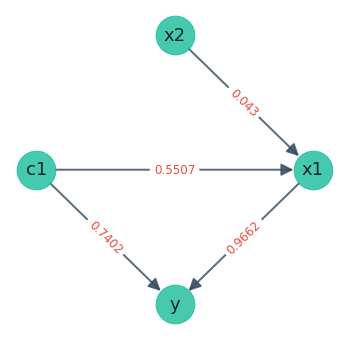

In [9]:
# plot structure model
sm = reg.graph_
sm = sm.get_largest_subgraph()
nx_util.plot_structure_model(sm, layout_method="circular", figsize=(6,6))

In [10]:
# weightをprint
nx_util.print_weights(sm)

[ x1 ] ---> [ y ]		Weight	0.96616
[ x2 ] ---> [ x1 ]		Weight	0.04299
[ c1 ] ---> [ x1 ]		Weight	0.55066
[ c1 ] ---> [ y ]		Weight	0.74017


## DAGClassifier

In [11]:
# 2値分類タスクに変換
y = y > np.median(y)
y = y.astype(int)

In [25]:
clf = DAGClassifier(
    threshold= 0.0, 
    #dist_type_schema = dist_type_schema,
    alpha = 0.0, # L1
    beta = 0.0,
    hidden_layer_units =None,
    standardize=False,
    enforce_dag=True,
    tabu_edges=None,
    tabu_parent_nodes=None,
    tabu_child_nodes=None,
    dependent_target = False
)

In [26]:
clf.fit(X, y)
y_pred = clf.predict(X)
y_pred_proba = clf.predict_proba(X)

In [27]:
print("Pred Label" ,y_pred)
print("Pred Proba ",y_pred_proba)

Pred Label [1 1 1 ... 1 0 0]
Pred Proba  [[0.23409319 0.76590681]
 [0.44476837 0.55523163]
 [0.3260628  0.6739372 ]
 ...
 [0.45221138 0.54778862]
 [0.67806828 0.32193172]
 [0.72245011 0.27754989]]


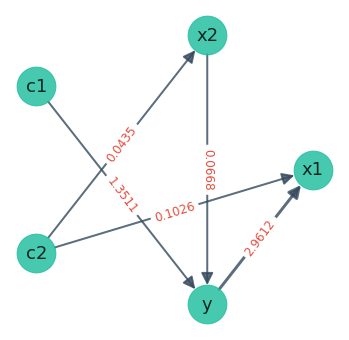

In [31]:
# plot structure model
sm = clf.graph_
sm = sm.get_largest_subgraph()
nx_util.plot_structure_model(sm, layout_method="circular", figsize=(6,6))

## DAGClassifier  with hidden_layer_units

In [16]:
dist_type_schema = {
    "x1" : "cont",
    "x2" : "cont",
    "c1" : "cont",
    "c2" : "bin",
    "y" : "bin"
}

In [17]:
clf = DAGClassifier(
    threshold= 0.1, 
    dist_type_schema = dist_type_schema,
    alpha = 0.0, # L1
    beta = 0.0,
    hidden_layer_units =None,
    standardize=False,
    enforce_dag=True,
    tabu_edges=None,
    tabu_parent_nodes=None,
    tabu_child_nodes=None,
    dependent_target = False
)

In [18]:
clf.fit(X, y)
y_pred = clf.predict(X)
y_pred_proba = clf.predict_proba(X)

In [19]:
print("Pred Label" ,y_pred)
print("Pred Proba ",y_pred_proba)

Pred Label [1 1 1 ... 1 0 0]
Pred Proba  [[0.23508549 0.76491451]
 [0.44483751 0.55516249]
 [0.32839495 0.67160505]
 ...
 [0.4544403  0.5455597 ]
 [0.67869914 0.32130086]
 [0.72195426 0.27804574]]


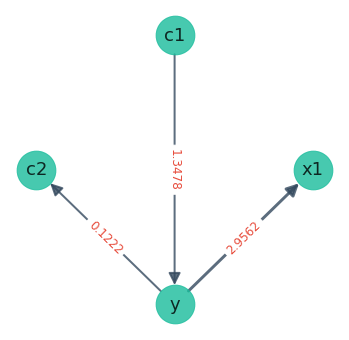

In [20]:
# plot structure model
sm = clf.graph_
sm = sm.get_largest_subgraph()
nx_util.plot_structure_model(sm, layout_method="circular", figsize=(6,6))

# from_pandas_lasso, from_pandas(pytorch)実行

## L1 Penalty付きNO TEARSで因果グラフ推定

In [21]:
# NOTEARSを実行, from_pandas_lassoでL1 penaltyをつけて推定することが可能
sm = from_pandas_lasso( 
    struct_data,
    beta = 0.15,  # 0.15
    tabu_edges = [],
    tabu_parent_nodes = None,
    tabu_child_nodes = None,
)
sm.threshold_till_dag() # DAGになるように閾値をあげる
#sm.remove_edges_below_threshold(0.2) # 

[ x1 ] ---> [ y ]		Weight	1.08730
[ c1 ] ---> [ x1 ]		Weight	0.29201
[ c1 ] ---> [ y ]		Weight	0.24506
[ c2 ] ---> [ x1 ]		Weight	0.73727
[ c2 ] ---> [ y ]		Weight	0.14375


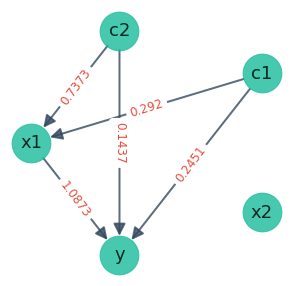

In [22]:
# weights pring
nx_util.print_weights(sm)

# plot sturecture model
nx_util.plot_structure_model(sm, layout_method="shell", layout_seed=1, figsize=(5,5))

## pytorchでNO TEARSで因果グラフ推定

In [23]:
# data typeを加味してpytorchを用いて推定
sm_pytorch = from_pandas_pytorch(
    struct_data, 
    dist_type_schema = dist_type_schema, 
    lasso_beta = 0, 
    ridge_beta = 0.01,
    w_threshold = 0.01, 
    use_bias = True
)
sm_pytorch.threshold_till_dag()
sm_pytorch.remove_edges_below_threshold(10) # 

[ x1 ] ---> [ y ]		Weight	2191.38135
[ x2 ] ---> [ y ]		Weight	62.67263
[ c1 ] ---> [ y ]		Weight	257.61075
[ c2 ] ---> [ x1 ]		Weight	12.84227
[ c2 ] ---> [ y ]		Weight	278.49945


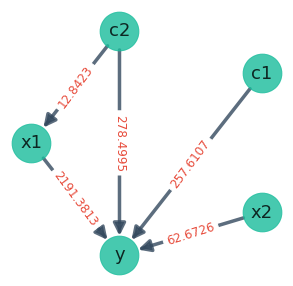

In [24]:
# weights pring
nx_util.print_weights(sm_pytorch)

# plot sturecture model
nx_util.plot_structure_model(sm_pytorch, layout_method="shell", layout_seed=1, figsize=(5,5))